## Set up the environment

In [1]:
# Load the Drive helper and mount
from google.colab import drive

# This will prompt for authorization.
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q https://dlcdn.apache.org/spark/spark-3.2.0/spark-3.2.0-bin-hadoop3.2.tgz
!tar xf spark-3.2.0-bin-hadoop3.2.tgz
!pip install -q findspark
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.2.0-bin-hadoop3.2"
!pip install pyspark
!pip install wavio

     |████████████████████████████████| 281.3 MB 39 kB/s 
     |████████████████████████████████| 198 kB 36.2 MB/s 
  Created wheel for pyspark: filename=pyspark-3.2.0-py2.py3-none-any.whl size=281805912 sha256=df8d50919fca18a38ba2a066fee79d6575a0466c0ee1fcd9b79daf8bd3f52ca0
  Stored in directory: /root/.cache/pip/wheels/0b/de/d2/9be5d59d7331c6c2a7c1b6d1a4f463ce107332b1ecd4e80718
Successfully built pyspark


In [3]:
import matplotlib.pyplot as plt
from scipy.io import wavfile
import os
from glob import glob
import numpy as np
import pandas as pd
from librosa.core import resample, to_mono
from tqdm import tqdm
import tensorflow as tf
import wavio
import sklearn
from tensorflow.keras.models import load_model
from kapre.time_frequency import STFT, Magnitude, ApplyFilterbank, MagnitudeToDecibel

## Preprocess the Dataset

### Parameters

In this section, we set the parameters of paths, the number of classes, deltatime, sample rate and so on. 

In [4]:
path_dataset = "/content/drive/MyDrive/FinalProject/wavfiles"
path_cleaned_dataset = "/content/drive/MyDrive/FinalProject/cleaned_dataset"
delta_time = float(1.0)
sample_rate = int(16000)
threshold = int(20)
delta_sample = int(delta_time * sample_rate)
N_CLASSES = 10

### Functions

In this section, we define function to clean the data. We need to remove the data whose the magnitate is lower than the thredshold, and we need to splite the dataset into smaller pieces. 

In [5]:
def sample(wave_data, wave_rate):
  #print(wave_data)
  #print(wave_rate)
  channel = wave_data.shape[1]
  #print(channel)
  if channel == 2:
    wave_data = to_mono(wave_data.T)
  elif channel == 1:
    wave_data = to_mono(wave_data.reshape(-1))
  wave_data = resample(wave_data, wave_rate, sample_rate)
  wave_data = wave_data.astype(np.int16)
  wave_rate = sample_rate
  #print(wave_data)
  return wave_data, wave_rate

In [6]:
def envelope(wave_data, wave_rate):
  wave_mask = []
  wave_data_series = pd.Series(wave_data).apply(np.abs)
  #print(wave_data_series)    
  wave_data_mean = wave_data_series.rolling(window=int(wave_rate/20),
                     min_periods=1,
                     center=True).max()
  #print(wave_data_mean)
  for i in wave_data_mean:
    if i > threshold:
      wave_mask.append(True)
    else:
      wave_mask.append(False)
  #print(mask)
  return wave_mask, wave_data_mean

In [7]:
def split(wave_data, wave_rate, path_dir_cleaned, name_wave):
  wave_length = wave_data.shape[0]
  count = 0
  while wave_data.shape[0] > delta_sample:
    wave_splited = wave_data[:delta_sample]
    wave_data = wave_data[delta_sample:]
    name_wave_splited = name_wave.split('.wav')[0] + "-" + str(count) + ".wav"
    path_wave_splited = os.path.join(path_dir_cleaned, name_wave_splited)
    if os.path.exists(path_wave_splited) is False:
      wavfile.write(path_wave_splited, wave_rate, wave_splited)
      #print(path_wave_splited)
    count = count + 1
  wave_splited = np.zeros(shape=(delta_sample,), dtype = np.int16)
  wave_splited[:wave_data.shape[0]] = wave_data
  name_wave_splited = name_wave.split('.wav')[0] + "-" + str(count) + ".wav"
  #print(name_wave_splited)
  path_wave_splited = os.path.join(path_dir_cleaned, name_wave_splited)
  if os.path.exists(path_wave_splited) is False:
    wavfile.write(path_wave_splited, wave_rate, wave_splited)
    #print(path_wave_splited)

### Load and Process the Data

In [8]:
for name_dir in os.listdir(path_dataset):
  #print(name_dir)
  path_dir = os.path.join(path_dataset, name_dir)
  path_dir_cleaned = os.path.join(path_cleaned_dataset, name_dir)
  #print(dir_cleaned)
  if os.path.exists(path_dir_cleaned) is False:
    os.mkdir(path_dir_cleaned)
  for name_wave in os.listdir(path_dir):
    path_wave = os.path.join(path_dir, name_wave)
    wave = wavio.read(path_wave)
    wave_data = wave.data.astype(np.float32, order='F')
    wave_rate = wave.rate
    wave_data, wave_rate = sample(wave_data, wave_rate)
    wave_mask, wave_data_mean = envelope(wave_data, wave_rate)
    wave_data = wave_data[wave_mask]
    split(wave_data, wave_rate, path_dir_cleaned, name_wave)

### Example

Here we show an example about data cleaning. 

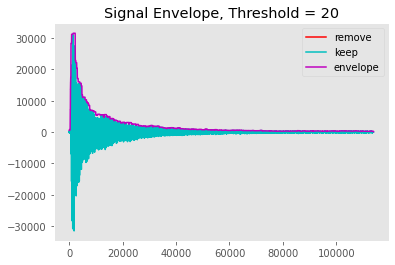

In [10]:
path_wave_example = "/content/drive/MyDrive/FinalProject/wavfiles/Acoustic_guitar/0356dec7.wav"
wave_example = wavio.read(path_wave_example)
wave_example_data = wave_example.data.astype(np.float32, order='F')
wave_example_rate = wave_example.rate
wave_example_data, wave_example_rate = sample(wave_example_data, wave_example_rate)
wave_example_mask, wave_example_envelop = envelope(wave_example_data, wave_example_rate)

plt.style.use('ggplot')
plt.title('Signal Envelope, Threshold = {}'.format(str(threshold)))
plt.plot(wave_example_data[np.logical_not(wave_example_mask)], color='r', label='remove')
plt.plot(wave_example_data[wave_example_mask], color='c', label='keep')
plt.plot(wave_example_envelop, color='m', label='envelope')
plt.grid(False)
plt.legend(loc='best')
plt.show()

## Create the Model

In this section, we use the models from Kapre. Here we can optimize DSP parameters, and it is consistent with 1D/2D tensorflow batch shapes. We define 3 models, they are con1D, con2D and LTSM. Below is the cite of Kapre. 

@inproceedings{choi2017kapre,
  title={Kapre: On-GPU Audio Preprocessing Layers for a Quick Implementation of Deep Neural Network Models with Keras},

  author={Choi, Keunwoo and Joo, Deokjin and Kim, Juho},

  booktitle={Machine Learning for Music Discovery Workshop at 34th International Conference on Machine Learning},

  year={2017},
  
  organization={ICML}
}

In [11]:
from tensorflow.keras import layers
from tensorflow.keras.layers import TimeDistributed, LayerNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.regularizers import l2
import kapre
from kapre.composed import get_melspectrogram_layer
import tensorflow as tf
import os

### 1-Dimensional Convolutional Neural Network

In [12]:
def Conv1D(N_CLASSES=10, SR=16000, DT=1.0):
    input_shape = (int(SR*DT), 1)
    i = get_melspectrogram_layer(input_shape=input_shape,
                                 n_mels=128,
                                 pad_end=True,
                                 n_fft=512,
                                 win_length=400,
                                 hop_length=160,
                                 sample_rate=SR,
                                 return_decibel=True,
                                 input_data_format='channels_last',
                                 output_data_format='channels_last')
    x = LayerNormalization(axis=2, name='batch_norm')(i.output)
    x = TimeDistributed(layers.Conv1D(8, kernel_size=(4), activation='tanh'), name='td_conv_1d_tanh')(x)
    x = layers.MaxPooling2D(pool_size=(2,2), name='max_pool_2d_1')(x)
    x = TimeDistributed(layers.Conv1D(16, kernel_size=(4), activation='relu'), name='td_conv_1d_relu_1')(x)
    x = layers.MaxPooling2D(pool_size=(2,2), name='max_pool_2d_2')(x)
    x = TimeDistributed(layers.Conv1D(32, kernel_size=(4), activation='relu'), name='td_conv_1d_relu_2')(x)
    x = layers.MaxPooling2D(pool_size=(2,2), name='max_pool_2d_3')(x)
    x = TimeDistributed(layers.Conv1D(64, kernel_size=(4), activation='relu'), name='td_conv_1d_relu_3')(x)
    x = layers.MaxPooling2D(pool_size=(2,2), name='max_pool_2d_4')(x)
    x = TimeDistributed(layers.Conv1D(128, kernel_size=(4), activation='relu'), name='td_conv_1d_relu_4')(x)
    x = layers.GlobalMaxPooling2D(name='global_max_pooling_2d')(x)
    x = layers.Dropout(rate=0.1, name='dropout')(x)
    x = layers.Dense(64, activation='relu', activity_regularizer=l2(0.001), name='dense')(x)
    o = layers.Dense(N_CLASSES, activation='softmax', name='softmax')(x)
    model = Model(inputs=i.input, outputs=o, name='1d_convolution')
    model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model

### 2-Dimensional Convolutional Neural Network

In [13]:
def Conv2D(N_CLASSES=10, SR=16000, DT=1.0):
    input_shape = (int(SR*DT), 1)
    i = get_melspectrogram_layer(input_shape=input_shape,
                                 n_mels=128,
                                 pad_end=True,
                                 n_fft=512,
                                 win_length=400,
                                 hop_length=160,
                                 sample_rate=SR,
                                 return_decibel=True,
                                 input_data_format='channels_last',
                                 output_data_format='channels_last')
    x = LayerNormalization(axis=2, name='batch_norm')(i.output)
    x = layers.Conv2D(8, kernel_size=(7,7), activation='tanh', padding='same', name='conv2d_tanh')(x)
    x = layers.MaxPooling2D(pool_size=(2,2), padding='same', name='max_pool_2d_1')(x)
    x = layers.Conv2D(16, kernel_size=(5,5), activation='relu', padding='same', name='conv2d_relu_1')(x)
    x = layers.MaxPooling2D(pool_size=(2,2), padding='same', name='max_pool_2d_2')(x)
    x = layers.Conv2D(16, kernel_size=(3,3), activation='relu', padding='same', name='conv2d_relu_2')(x)
    x = layers.MaxPooling2D(pool_size=(2,2), padding='same', name='max_pool_2d_3')(x)
    x = layers.Conv2D(32, kernel_size=(3,3), activation='relu', padding='same', name='conv2d_relu_3')(x)
    x = layers.MaxPooling2D(pool_size=(2,2), padding='same', name='max_pool_2d_4')(x)
    x = layers.Conv2D(32, kernel_size=(3,3), activation='relu', padding='same', name='conv2d_relu_4')(x)
    x = layers.Flatten(name='flatten')(x)
    x = layers.Dropout(rate=0.2, name='dropout')(x)
    x = layers.Dense(64, activation='relu', activity_regularizer=l2(0.001), name='dense')(x)
    o = layers.Dense(N_CLASSES, activation='softmax', name='softmax')(x)
    model = Model(inputs=i.input, outputs=o, name='2d_convolution')
    model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model

### Long Short Term Memory

In [14]:
def LSTM(N_CLASSES=10, SR=16000, DT=1.0):
  input_shape = (delta_sample, 1)
  i = get_melspectrogram_layer(input_shape=input_shape,
                  n_mels=128,
                  pad_end=True,
                  n_fft=512,
                  win_length=400,
                  hop_length=160,
                  sample_rate=SR,
                  return_decibel=True,
                  input_data_format='channels_last',
                  output_data_format='channels_last',
                  name='2d_convolution')
  x = LayerNormalization(axis=2, name='batch_norm')(i.output)
  x = TimeDistributed(layers.Reshape((-1,)), name='reshape')(x)
  s = TimeDistributed(layers.Dense(64, activation='tanh'),
                      name='td_dense_tanh')(x)
  x = layers.Bidirectional(layers.LSTM(32, return_sequences=True),
                        name='bidirectional_lstm')(s)
  x = layers.concatenate([s, x], axis=2, name='skip_connection')
  x = layers.Dense(64, activation='relu', name='dense_1_relu')(x)
  x = layers.MaxPooling1D(name='max_pool_1d')(x)
  x = layers.Dense(32, activation='relu', name='dense_2_relu')(x)
  x = layers.Flatten(name='flatten')(x)
  x = layers.Dropout(rate=0.2, name='dropout')(x)
  x = layers.Dense(32, activation='relu',
              activity_regularizer=l2(0.001),
              name='dense_3_relu')(x)
  o = layers.Dense(N_CLASSES, activation='softmax', name='softmax')(x)
  model = Model(inputs=i.input, outputs=o, name='long_short_term_memory')
  model.compile(optimizer='adam',
         loss='categorical_crossentropy',
         metrics=['accuracy'])

  return model

## Train the Model

In this section, we train the data in 3 models. They all behave very well. 

In [15]:
import tensorflow as tf
from tensorflow.keras.callbacks import CSVLogger, ModelCheckpoint
from tensorflow.keras.utils import to_categorical
import os
from scipy.io import wavfile
import pandas as pd
import numpy as np
from sklearn.utils.class_weight import compute_class_weight
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from glob import glob

In [16]:
class DataGenerator(tf.keras.utils.Sequence):
    def __init__(self, wav_paths, labels, sr, dt, n_classes,
                 batch_size=32, shuffle=True):
        self.wav_paths = wav_paths
        self.labels = labels
        self.sr = sr
        self.dt = dt
        self.n_classes = n_classes
        self.batch_size = batch_size
        self.shuffle = True
        self.on_epoch_end()


    def __len__(self):
        return int(np.floor(len(self.wav_paths) / self.batch_size))


    def __getitem__(self, index):
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        wav_paths = [self.wav_paths[k] for k in indexes]
        labels = [self.labels[k] for k in indexes]

        # generate a batch of time data
        X = np.empty((self.batch_size, int(self.sr*self.dt), 1), dtype=np.float32)
        Y = np.empty((self.batch_size, self.n_classes), dtype=np.float32)

        for i, (path, label) in enumerate(zip(wav_paths, labels)):
            rate, wav = wavfile.read(path)
            X[i,] = wav.reshape(-1, 1)
            Y[i,] = to_categorical(label, num_classes=self.n_classes)

        return X, Y


    def on_epoch_end(self):
        self.indexes = np.arange(len(self.wav_paths))
        if self.shuffle:
            np.random.shuffle(self.indexes)

In [17]:
def train(model_type):
  src_root = "/content/drive/MyDrive/FinalProject/cleaned_dataset"
  sr = sample_rate
  dt = delta_time
  batch_size = 16
  params = {'N_CLASSES':len(os.listdir(src_root)),
        'SR':sr,
        'DT':dt}
  models = {'conv1d':Conv1D(**params),
        'conv2d':Conv2D(**params),
        'lstm':  LSTM(**params)}
  assert model_type in models.keys(), '{} not an available model'.format(model_type)
  csv_path = os.path.join('/content/drive/MyDrive/FinalProject/logs', '{}_history.csv'.format(model_type))

  wav_paths = glob('{}/**'.format(src_root), recursive=True)
  wav_paths = [x for x in wav_paths if '.wav' in x]
  classes = sorted(os.listdir(src_root))
  le = LabelEncoder()
  le.fit(classes)
  labels = [os.path.split(x)[0].split('/')[-1] for x in wav_paths]
  labels = le.transform(labels)
  wav_train, wav_val, label_train, label_val = train_test_split(wav_paths,
                                  labels,
                                  test_size=0.3,
                                  random_state=0)
  print("Train number: ")
  print(len(wav_train))
  print("Test number: ")
  print(len(wav_val))

  tg = DataGenerator(wav_train, label_train, sr, dt,
             params['N_CLASSES'], batch_size=batch_size)
  vg = DataGenerator(wav_val, label_val, sr, dt,
             params['N_CLASSES'], batch_size=batch_size)
  model = models[model_type]
  cp = ModelCheckpoint('/content/drive/MyDrive/FinalProject/models/{}.h5'.format(model_type), monitor='val_loss',
              save_best_only=True, save_weights_only=False,
              mode='auto', save_freq='epoch', verbose=1)
  csv_logger = CSVLogger(csv_path, append=False)
  model.fit(tg, validation_data=vg,
       epochs=30, verbose=1,
       callbacks=[csv_logger, cp])

### 1-Dimensional Convolutional Neural Network 

In [ ]:
train('conv1d')

Train number: 
1080
Test number: 
463
Epoch 1/30
67/67 [==============================] - ETA: 0s - loss: 2.0895 - accuracy: 0.2817

### 2-Dimensional Convolutional Neural Network

In [ ]:
train('conv2d')

### Long Short Term Memory

In [ ]:
train('lstm')

## Plot

Here we plot the relation between accuracy and the number of epochs. We can see that when the number of epochs is getting larger, the accuracy is getting closer to 1. 

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

In [ ]:
log_csvs = sorted(os.listdir('/content/drive/MyDrive/FinalProject/logs'))
log_csvs = [x for x in log_csvs if '.csv' in x]
plot_labels = ['Conv 1D', 'Conv 2D', 'LSTM']
plot_colors = ['r', 'm', 'c']
fig, ax = plt.subplots(1, 3, sharey=True, figsize=(16,5))

for i, (fn, label, c) in enumerate(zip(log_csvs, plot_labels, plot_colors)):
    csv_path = os.path.join('/content/drive/MyDrive/FinalProject/logs', fn)
    df = pd.read_csv(csv_path)
    ax[i].set_title(label, size=16)
    ax[i].plot(df.accuracy, color=c, label='train')
    ax[i].plot(df.val_accuracy, ls='--', color=c, label='test')
    ax[i].legend(loc='upper left')
    ax[i].tick_params(axis='both', which='major', labelsize=12)
    ax[i].set_ylim([0,1.0])

fig.text(0.5, 0.02, 'Epochs', ha='center', size=14)
fig.text(0.08, 0.5, 'Accuracy', va='center', rotation='vertical', size=14)
plt.show()

## Predict

In this section, we use the previous model to make a prediction based on the origianal dataset. We can see that the model also behaves very well. 

In [ ]:
def make_prediction(model_type):
    path_model = csv_path = os.path.join('/content/drive/MyDrive/FinalProject/models', '{}.h5'.format(model_type))
    model = load_model(path_model,
        custom_objects={'STFT':STFT,
                        'Magnitude':Magnitude,
                        'ApplyFilterbank':ApplyFilterbank,
                        'MagnitudeToDecibel':MagnitudeToDecibel})
    wav_paths = glob('{}/**'.format(path_dataset), recursive=True)
    wav_paths = sorted([x.replace(os.sep, '/') for x in wav_paths if '.wav' in x])
    classes = sorted(os.listdir(path_dataset))
    labels = [os.path.split(x)[0].split('/')[-1] for x in wav_paths]
    le = LabelEncoder()
    y_true = le.fit_transform(labels)
    results = []
    correct = 0
    wrong = 0

    for z, wav_fn in tqdm(enumerate(wav_paths), total=len(wav_paths)):
        wave = wavio.read(wav_fn)
        wave_data = wave.data.astype(np.float32, order='F')
        wave_rate = wave.rate
        wave_data, wave_rate = sample(wave_data, wave_rate)
        wave_mask, wave_data_mean = envelope(wave_data, wave_rate)
        wave_data = wave_data[wave_mask]
        batch = []

        for i in range(0, wave_data.shape[0], delta_sample):
            wave_sample = wave_data[i:i+delta_sample]
            wave_sample = wave_sample.reshape(-1, 1)
            if wave_sample.shape[0] < delta_sample:
                tmp = np.zeros(shape=(delta_sample, 1), dtype=np.float32)
                tmp[:wave_sample.shape[0],:] = wave_sample.flatten().reshape(-1, 1)
                wave_sample = tmp
            batch.append(wave_sample)
        X_batch = np.array(batch, dtype=np.float32)
        y_pred = model.predict(X_batch)
        y_mean = np.mean(y_pred, axis=0)
        y_pred = np.argmax(y_mean)
        real_class = os.path.dirname(wav_fn).split('/')[-1]
        print('Actual class: {}, Predicted class: {}'.format(real_class, classes[y_pred]))
        results.append(y_mean)
        if real_class == classes[y_pred]:
          correct = correct + 1
        else:
          wrong = wrong + 1


    np.save(os.path.join('/content/drive/MyDrive/FinalProject/prediction/', model_type), np.array(results))
    
    print("Correct prediction number:")
    print(correct)
    print("Wrong prediction number:")
    print(wrong)

### 1-Dimensional Convolutional Neural Network

In [ ]:
make_prediction('conv1d')

### 2-Dimensional Convolutional Neural Network

In [ ]:
make_prediction('conv2d')

### Long Short Term Memory

In [ ]:
make_prediction('lstm')

## ROC curve and Confusion Matrix

In [ ]:
import pandas as pd
import numpy as np
from sklearn.metrics import roc_auc_score, roc_curve, auc, confusion_matrix, plot_confusion_matrix
from glob import glob
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
import os
import matplotlib.pyplot as plt
import pylab
import seaborn as sns

In [ ]:
y_pred = np.load('/content/drive/MyDrive/FinalProject/prediction/lstm.npy')

In [ ]:
wav_paths = glob('{}/**'.format('/content/drive/MyDrive/FinalProject/wavfiles'), recursive=True)
wav_paths = sorted([x.replace(os.sep, '/') for x in wav_paths if '.wav' in x])
classes = sorted(os.listdir('/content/drive/MyDrive/FinalProject/wavfiles'))
labels = [os.path.split(x)[0].split('/')[-1] for x in wav_paths]
le = LabelEncoder()
y_true = le.fit_transform(labels)
y_hot = to_categorical(y_true)
y_pred_le = np.argmax(y_pred, axis=1)
y_pred_labels = [classes[x] for x in y_pred_le]
y_true_labels = [classes[x] for x in y_true]

In [ ]:
n_classes = len(set(y_true))
print(n_classes)

In [ ]:
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_hot[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])



Compute micro-average ROC curve and ROC area

In [ ]:
fpr["micro"], tpr["micro"], _ = roc_curve(y_hot.ravel(), y_pred.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

In [ ]:
# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure(figsize=(10,10))
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

colors = []
cm = pylab.get_cmap('nipy_spectral')
for i in range(n_classes):
    color = cm(1.*i/n_classes)
    colors.append(color)
unique_labels = np.unique(labels)

for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='{0} (area = {1:0.2f})'.format(unique_labels[i], roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multi Class ROC')
legend = plt.legend()
legend._legend_box.align = "right"
plt.legend(loc="lower right")
plt.show()

In [ ]:
conf_mat = confusion_matrix(y_true_labels, y_pred_labels, labels=unique_labels)
df_cm = pd.DataFrame(conf_mat, index = unique_labels,
                     columns = unique_labels)
plt.figure(figsize = (10,8))
plt.title('Confusion Matrix')
sns.heatmap(df_cm, annot=True, cmap='viridis')
plt.show()